In [ ]:
# Install R and required packages in Colab
# Install R and required packages in Colab
!apt-get update
!apt-get install -y r-base
!apt-get install -y r-cran-dplyr r-cran-dalex r-cran-dalextra r-cran-ggplot2 r-cran-readxl r-cran-rcolorbrewer r-cran-plotrix r-cran-h2o r-cran-bit64 r-cran-entropy




In [ ]:
# Load the R magic
%load_ext rpy2.ipython


In [ ]:
# Install R packages
%%R
install.packages(c("dplyr", "DALEX", "DALEXtra", "ggplot2", "readxl", "RColorBrewer", "plotrix", "h2o", "bit64", "entropy"))


In [ ]:
%%R
# Load R libraries
library(dplyr)
library(DALEX)
library(DALEXtra)
library(ggplot2)
library(readxl)
library(RColorBrewer)
library(plotrix)
library(h2o)
library(bit64)
library(entropy)

# Initialize h2o
h2o.init()


In [ ]:
from google.colab import files

# Upload file from local machine
uploaded = files.upload()


In [ ]:
# Check the uploaded file names
import os

# List the files in the current directory
os.listdir()


In [ ]:
%%R
# Load the dataset from the uploaded file
library(readxl)

# Replace 'filename.xlsx' with the name of the file you uploaded
mydata <- read_excel("M1cylinderical.xlsx")


Streaming output truncated to the last 5000 lines.
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |==================================================================

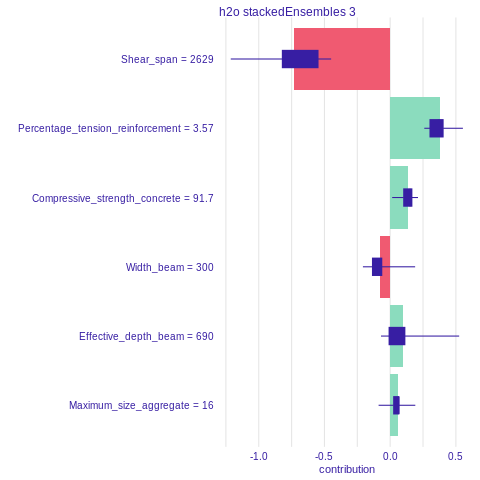

In [ ]:
# Preprocess data for training
%%R
end_row <- 150
mydata_matrix <- as.matrix(mydata)

######### Data for Train stage#############
end_row= 150
mydata_matrix=as.matrix(mydata)

Effective_depth_beam=as.numeric(mydata_matrix[1:end_row,2])

Shear_span=as.numeric(mydata_matrix[1:end_row,3])

Maximum_size_aggregate=as.numeric(mydata_matrix[1:end_row,4])

Compressive_strength_concrete=as.numeric(mydata_matrix[1:end_row,5])

Percentage_tension_reinforcement=as.numeric(mydata_matrix[1:end_row,6])

Width_beam=as.numeric(mydata_matrix[1:end_row,7])


Ultimate_Shear_Strength=as.numeric(mydata_matrix[1:end_row,1])


DAT_train = data.frame( Ultimate_Shear_Strength,Effective_depth_beam, Shear_span, Maximum_size_aggregate,Compressive_strength_concrete,Percentage_tension_reinforcement,Width_beam)



######### Data for Test stage#############


end_row= 250
mydata_matrix2=as.matrix(mydata)

Effective_depth_beam=as.numeric(mydata_matrix2[151:end_row,2])

Shear_span=as.numeric(mydata_matrix2[151:end_row,3])

Maximum_size_aggregate=as.numeric(mydata_matrix2[151:end_row,4])

Compressive_strength_concrete=as.numeric(mydata_matrix2[151:end_row,5])

Percentage_tension_reinforcement=as.numeric(mydata_matrix2[151:end_row,6])

Width_beam=as.numeric(mydata_matrix[151:end_row,7])

Ultimate_Shear_Strength=as.numeric(mydata_matrix2[151:end_row,1])


DAT_test2 = data.frame( Ultimate_Shear_Strength,Effective_depth_beam, Shear_span, Maximum_size_aggregate,Compressive_strength_concrete,Percentage_tension_reinforcement,Width_beam)


############# Train data using h2o.deep learning #############
Train_data<- as.h2o(DAT_train)
model_deep_train <- h2o.deeplearning(x= 2:7, y = 1, training_frame= Train_data,nfolds = 25,

                                     fold_assignment = "Modulo" ,
                                     keep_cross_validation_predictions = TRUE ,

                                     hidden = c(10,10),
                                     epochs = 1000,
                                     train_samples_per_iteration = -1,
                                     target_ratio_comm_to_comp = 0.0008,
                                     seed = -1,
                                     adaptive_rate = TRUE,
                                     rho = 0.99,
                                     epsilon = 1e-08,
                                     rate = 0.00005,

                                     rate_decay = 1,
                                     momentum_start = 0,
                                     momentum_ramp = 1e+06,
                                     momentum_stable = 0,
                                     nesterov_accelerated_gradient = TRUE,
                                     input_dropout_ratio = 0.009,
                                     activation = "Tanh"

)

# loading test data in h2o
newdata<- as.h2o(DAT_test2[,2:7])
# Observed output
y=DAT_test2[,1]
### predictions phase3
#y_hat <- h2o.predict(model_deep_train,newdata)

############# Explain-er of  h2o.deep learning #############


explainer_h2o_deeplearning <- DALEXtra::explain_h2o(model = model_deep_train,
                                                    data =   DAT_test2[,2:7],
                                                    y = mydata_matrix2[151:end_row,1],
                                                    label = "h2o df",
                                                    colorize = FALSE)

###### Show the predicted results
ypredicted_dl <- explainer_h2o_deeplearning$y_hat

ypredicted_dl

mp_h2o_deeplearning <- model_performance(explainer_h2o_deeplearning)

mp_h2o_deeplearning



############# Train data using h2o.Gradient boosted machine (GBM) #############

model_gbm_train <- h2o.gbm(x= 2:7, y = 1, training_frame= Train_data,



                           ntrees = 10,
                           max_depth = 10,
                           min_rows = 6,
                           learn_rate = 0.9,
                           nfolds = 25,
                           fold_assignment = "Modulo",
                           keep_cross_validation_predictions = TRUE,
                           seed = 10   )


############# Explain-er of  h2o.Gradient boosted machine #############



explainer_h2o_GBM <- DALEXtra::explain_h2o(model = model_gbm_train,
                                           data =   DAT_test2[,2:7],
                                           y = mydata_matrix2[151:end_row,1],
                                           label = "h2o GBM",
                                           colorize = FALSE
)


###### Show the predicted results
ypredicted_gbm <- explainer_h2o_GBM$y_hat

ypredicted_gbm



############# Train data using h2o.Generalized Linear Model (GLM)#############
Train_data<- as.h2o(DAT_train)
model_glm_train <- h2o.glm(x= 2:7, y = 1, training_frame= Train_data)


############# Explain-er of  h2o. Generalized Linear Model (GLM) #############
explainer_h2o_GLM <- DALEXtra::explain_h2o(model = model_glm_train,
                                           data =   DAT_test2[,2:7],
                                           y = mydata_matrix2[151:end_row,1],

                                           label = "h2o GLM",
                                           colorize = FALSE)

###### Show the predicted results
ypredicted_GLM <- explainer_h2o_GLM$y_hat

ypredicted_GLM




############# Train data using h2o.Random Forest (RF)#############
Train_data<- as.h2o(DAT_train)
model_RF_train <- h2o.randomForest(x= 2:7, y = 1, training_frame= Train_data,
                                   ntrees = 10,
                                   nfolds = 25,
                                   fold_assignment = "Modulo",
                                   keep_cross_validation_predictions = TRUE,
                                   seed = 10 )



############# Explain-er of  h2o. Random forest (RF) #############
explainer_h2o_RF<- DALEXtra::explain_h2o(model = model_RF_train ,

                                         data =   DAT_test2[,2:7],
                                         y = mydata_matrix2[151:end_row,1],

                                         label = "h2o RF",
                                         colorize = FALSE)



###### Show the predicted results
ypredicted_RF <- explainer_h2o_RF$y_hat

ypredicted_RF



######################################H2O Stacked Ensemble#####################

##############H2O Stacked Ensemble (Random Forest, Gradient Boosted Machine#############

model_stackedEnsembles_train <- h2o.stackedEnsemble(x= 2:7, y = 1, training_frame= Train_data,

                                                    model_id = "my_ensemble_binomial",
                                                    base_models = list(model_gbm_train,model_RF_train ))



############# Explain-er of  h2o. Stacked Ensemble #############
explainer_h2o_stackedEnsemble<- DALEXtra::explain_h2o(model = model_stackedEnsembles_train ,
                                                      data =   DAT_test2[,2:7],
                                                      y = mydata_matrix2[151:end_row,1],

                                                      label = "h2o stackedEnsembles",
                                                      colorize = FALSE)


###### Show the predicted results
ypredicted_stackedEnsemble <- explainer_h2o_stackedEnsemble$y_hat

ypredicted_stackedEnsemble




##############H2O Stacked Ensemble2 (Deep learning- Gradient Boosted Machine)#############

model_stackedEnsembles2_train <- h2o.stackedEnsemble(x= 2:7, y = 1, training_frame= Train_data,

                                                     model_id = "my_ensemble_bi",
                                                     base_models = list(model_gbm_train,model_deep_train ))


############# Explain-er of  h2o. Stacked Ensemble 2 #############

explainer_h2o_stackedEnsemble2 <- DALEXtra::explain_h2o(model = model_stackedEnsembles2_train ,
                                                        data =   DAT_test2[,2:7],
                                                        y = mydata_matrix2[151:end_row,1],

                                                        label = "h2o stackedEnsembles 2",
                                                        colorize = FALSE)



###### Show the predicted results
ypredicted_stackedEnsemble2 <- explainer_h2o_stackedEnsemble2$y_hat

ypredicted_stackedEnsemble2


##############H2O Stacked Ensemble3 (Deep learning- Gradient Boosted Machine-Random forest)#############

model_stackedEnsembles3_train <- h2o.stackedEnsemble(x= 2:7, y = 1, training_frame= Train_data,

                                                     model_id = "my_ensemble_bi",
                                                     base_models = list(model_gbm_train,model_deep_train,model_RF_train ))


############# Explain-er of  h2o. Stacked Ensemble 3#############
explainer_h2o_stackedEnsemble3 <- DALEXtra::explain_h2o(model = model_stackedEnsembles3_train ,
                                                        data =   DAT_test2[,2:7],
                                                        y = mydata_matrix2[151:end_row,1],
                                                        label = "h2o stackedEnsembles 3",
                                                        colorize = FALSE)



###### Show the predicted results
ypredicted_stackedEnsemble3 <- explainer_h2o_stackedEnsemble3$y_hat

ypredicted_stackedEnsemble3
#####performance indices###########
mp_h2o_deeplearning <- model_performance(explainer_h2o_deeplearning)

mp_h2o_GBM <- model_performance(explainer_h2o_GBM)

mp_h2o_GLM <- model_performance(explainer_h2o_GLM )

mp_h2o_RF <- model_performance(explainer_h2o_RF )

mp_h2o_stackedEnsemble <- model_performance(explainer_h2o_stackedEnsemble )

mp_h2o_stackedEnsemble2 <- model_performance(explainer_h2o_stackedEnsemble2 )

mp_h2o_stackedEnsemble3 <- model_performance(explainer_h2o_stackedEnsemble3 )


mp_h2o_deeplearning
mp_h2o_GBM
mp_h2o_RF
mp_h2o_GLM
mp_h2o_stackedEnsemble
mp_h2o_stackedEnsemble2
mp_h2o_stackedEnsemble3

####################Visualization of Feature Importance (Variable Importance) #############
# deep learning
vi_h2o_dl <- model_parts(explainer_h2o_deeplearning)
#plot(vi_h2o_dl)

# Gradient boosted Machine GBM
vi_h2o_GBM <- model_parts(explainer_h2o_GBM)
#plot(vi_h2o_GBM)

# Generalized Linear Models GLM
vi_h2o_GLM <- model_parts(explainer_h2o_GLM)
#plot(vi_h2o_GLM)

# Random Forest

vi_h2o_RF <- model_parts(explainer_h2o_RF)
#plot(vi_h2o_RF)

#stacked-Ensembles 1 (Random Forest, Gradient boosted Machine)

vi_h2o_stacked_Ensembles <- model_parts(explainer_h2o_stackedEnsemble)
#plot(vi_h2o_stacked_Ensembles)

#stacked-Ensembles 2 (deep learning , Gradient boosted Machine)

vi_h2o_stacked_Ensembles2 <- model_parts(explainer_h2o_stackedEnsemble2)
#plot(vi_h2o_stacked_Ensembles2)

#stacked-Ensembles 3 (deep learning , Gradient boosted Machine- Random forest )

vi_h2o_stacked_Ensembles3 <- model_parts(explainer_h2o_stackedEnsemble3)
#plot(vi_h2o_stacked_Ensembles3)
#plot(vi_h2o_dl, vi_h2o_RF, vi_h2o_GBM,vi_h2o_GLM,
# vi_h2o_stacked_Ensembles, vi_h2o_stacked_Ensembles2 , vi_h2o_stacked_Ensembles3 )



############### Variable response#################
###Partial Dependence Plot

#plot(pdp_h2o_deeplearning, pdp_h2o_GBM,pdp_h2o_RF,pdp_h2o_GLM ,

#    pdp_h2o_stackedEnsemble, pdp_h2o_stackedEnsemble2,

#  pdp_h2o_stackedEnsemble3 )

###Accumulated Local Effects plot

#######Prediction understanding####

New_Ultimate_shear <- DAT_test2[,2:7]
# Gradient boosted machine
pb_h2o_GBM <- predict_parts(explainer_h2o_GBM, new_observation = New_Ultimate_shear, type = "break_down")



pb_h2o_GBM_shap <- predict_parts(explainer_h2o_GBM, new_observation = New_Ultimate_shear, type = "shap")



# Generalized Linear Model

pb_h2o_GLM <- predict_parts(explainer_h2o_GLM, new_observation = New_Ultimate_shear, type = "break_down")



# Random Forest
pb_h2o_RF <- predict_parts(explainer_h2o_RF, new_observation = New_Ultimate_shear, type = "break_down")



pb_h2o_RF_shap <- predict_parts(explainer_h2o_RF, new_observation = New_Ultimate_shear, type = "shap")


# Deep Learning
pb_h2o_deeplearning <- predict_parts(explainer_h2o_deeplearning, new_observation = New_Ultimate_shear, type = "break_down")



pb_h2o_deeplearning_shap <- predict_parts(explainer_h2o_deeplearning, new_observation = New_Ultimate_shear, type = "shap")



# Stacked Ensemble

pb_h2o_stackedEnsemble <- predict_parts(explainer_h2o_stackedEnsemble, new_observation = New_Ultimate_shear, type = "break_down")



pb_h2o_stackedEnsemble_shap <- predict_parts(explainer_h2o_stackedEnsemble, new_observation = New_Ultimate_shear, type = "shap")





# Stacked Ensemble 2

pb_h2o_stackedEnsemble2 <- predict_parts(explainer_h2o_stackedEnsemble2, new_observation = New_Ultimate_shear, type = "break_down")



pb_h2o_stackedEnsemble2_shap <- predict_parts(explainer_h2o_stackedEnsemble2, new_observation = New_Ultimate_shear, type = "shap")



# Stacked Ensemble 3

pb_h2o_stackedEnsemble3 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear, type = "break_down")



pb_h2o_stackedEnsemble3_shap <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear, type = "shap")



################################ point-shap-break down#############################
##### label 1#####
##### label 1#####
New_Ultimate_shear_p1 <- DAT_test2[9,2:7]

New_Ultimate_shear_p2 <- DAT_test2[34,2:7]

New_Ultimate_shear_p3 <- DAT_test2[74,2:7]

New_Ultimate_shear_p4 <- DAT_test2[95,2:7]

##### label 2#####

New_Ultimate_shear_p5 <- DAT_test2[6,2:7]

New_Ultimate_shear_p6 <- DAT_test2[17,2:7]

New_Ultimate_shear_p7 <- DAT_test2[55,2:7]

New_Ultimate_shear_p8 <- DAT_test2[56,2:7]

New_Ultimate_shear_p9 <- DAT_test2[61,2:7]

New_Ultimate_shear_p10 <- DAT_test2[67,2:7]

New_Ultimate_shear_p11 <- DAT_test2[78,2:7]

##### label 3#####

New_Ultimate_shear_p12 <- DAT_test2[3,2:7]

New_Ultimate_shear_p13 <- DAT_test2[62,2:7]

New_Ultimate_shear_p14 <- DAT_test2[82,2:7]

New_Ultimate_shear_p15 <- DAT_test2[84,2:7]

##### label 4#####

New_Ultimate_shear_p16 <- DAT_test2[25,2:7]

############# Shap and break down for ensemble 3 M1#####################

pb_h2o_stackedEnsemble3_p1 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p1, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p1 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p1, type = "shap")

pb_h2o_stackedEnsemble3_p2 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p2, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p2 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p2, type = "shap")


pb_h2o_stackedEnsemble3_p3 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p3, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p3 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p3, type = "shap")


pb_h2o_stackedEnsemble3_p4 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p4, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p4 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p4, type = "shap")

pb_h2o_stackedEnsemble3_p5 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p5, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p5 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p5, type = "shap")

pb_h2o_stackedEnsemble3_p6 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p6, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p6 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p6, type = "shap")

pb_h2o_stackedEnsemble3_p7 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p7, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p7 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p7, type = "shap")

pb_h2o_stackedEnsemble3_p8 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p8, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p8 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p8, type = "shap")


pb_h2o_stackedEnsemble3_p9 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p9, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p9 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p9, type = "shap")


pb_h2o_stackedEnsemble3_p10 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p10, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p10 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p10, type = "shap")

pb_h2o_stackedEnsemble3_p11 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p11, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p11 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p11, type = "shap")


pb_h2o_stackedEnsemble3_p12 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p12, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p12 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p12, type = "shap")


pb_h2o_stackedEnsemble3_p13 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p13, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p13 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p13, type = "shap")


pb_h2o_stackedEnsemble3_p14 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p14, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p14 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p14, type = "shap")

pb_h2o_stackedEnsemble3_p15 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p15, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p15 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p15, type = "shap")

pb_h2o_stackedEnsemble3_p16 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p16, type = "break_down")


pb_h2o_stackedEnsemble3_shap_p16 <- predict_parts(explainer_h2o_stackedEnsemble3, new_observation = New_Ultimate_shear_p16, type = "shap")
plot(pb_h2o_stackedEnsemble3_shap_p15)



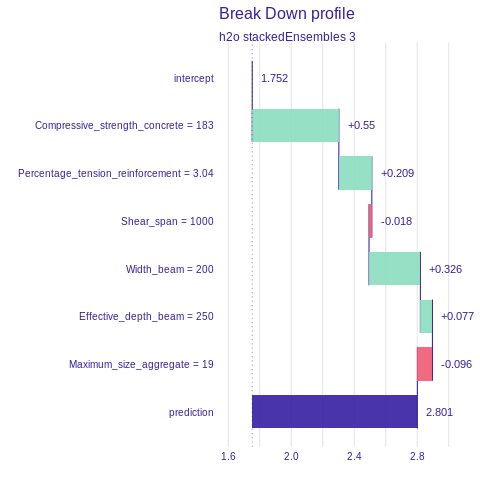

In [ ]:

%%R
# Load necessary library
library(ggplot2)

plot(pb_h2o_stackedEnsemble3_p16)

